In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tslearn
!pip install minisom
!pip install dbscan1d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=4344764ca83ee8454fe7dee41b7e33ca7fdfeab02a31901c5f1b1427f893fc5e
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 1.4 MB 11.2 MB/s 
     |████████████████████████████████| 96 kB 5.0 MB/s 
     |████████████████████████████████| 843 kB 43.0 MB/s 
     |████████████████████████████████| 69 kB 7.3 MB/s 
     |████████████████████████████████| 42 kB 907 kB/s 
  Attempting uninstal

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from statsmodels.nonparametric.smoothers_lowess import lowess


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
full_dataset_shock = pd.read_csv('/content/drive/MyDrive/ABM/shock_300_07_06_1.csv', sep=',') #out_shock_03_06_1
full_dataset_shock.head()

Unnamed: 0  noise_traders  noise_traders_cash  noise_traders_wealth  \
0           0            200                3000                    10   
1           1            200                3000                    10   
2           2            200                3000                    10   
3           3            200                3000                    10   
4           4            200                3000                    10   

   market_maker_cash  market_maker_wealth  mm_type1  mm_type2  mm_type3  \
0             200000                 1000         2         3         1   
1             200000                 1000         2         3         1   
2             200000                 1000         2         3         1   
3             200000                 1000         2         3         1   
4             200000                 1000         2         3         1   

   mm_spread_width_type1  ...  long_term_cash  long_term_wealth  high_freq  \
0                  0.005  ...            3000                50         70   
1                  0.005  ...            3000                50         70   
2                  0.005  ...            3000                50         70   
3                  0.005  ...            3000                50         70   
4                  0.005  ...            3000                50         70   

   high_freq_cash  high_freq_wealth  high_freq_lag  high_freq_threshold  \
0            1000               100             20                 0.01   
1            1000               100             20                 0.01   
2            1000               100             20                 0.01   
3            1000               100             20                 0.01   
4            1000               100             20                 0.01   

   shock_step  shock_price_change  \
0         300                 0.9   
1         300                 0.9   
2         300                 0.9   
3         300                 0.9   
4         300                 0.9   

                                                 res  
0  0.00698, 0.0072, 0.00644, 0.00651, 0.00674, 0....  
1  0.01361, 0.01254, 0.01036, 0.0078, 0.00551, 0....  
2  0.00697, 0.0091, 0.00943, 0.01107, 0.01222, 0....  
3  0.00921, 0.00793, 0.00876, 0.0084, 0.00809, 0....  
4  0.00627, 0.00484, 0.00787, 0.00924, 0.00865, 0...  

[5 rows x 28 columns]

In [5]:
# Cliustering data with synthetic shoch
# Extracting data
mySeries_sh = np.array([list(map(float, g.split(', '))) for g in full_dataset_shock.res.values])
mySeries_sh

array([[0.00698, 0.0072 , 0.00644, ..., 0.01051, 0.00978, 0.00924],
       [0.01361, 0.01254, 0.01036, ..., 0.00361, 0.00516, 0.00869],
       [0.00697, 0.0091 , 0.00943, ..., 0.01948, 0.01956, 0.01164],
       ...,
       [0.00773, 0.00788, 0.01187, ..., 0.01403, 0.01525, 0.0138 ],
       [0.0077 , 0.00632, 0.0109 , ..., 0.01887, 0.01378, 0.00623],
       [0.00833, 0.01102, 0.01202, ..., 0.00674, 0.00438, 0.00639]])

In [6]:
# Leave only data after shock
max_len = max(len(i) for i in mySeries_sh)
print(max_len)
longest_series = None
indexes = []
for i in range(len(mySeries_sh)):
    if len(mySeries_sh[i]) != max_len:
      indexes.append(i)

mySeries_shock = list(mySeries_sh[y][60:160] for y in range(len(mySeries_sh)) if y not in indexes)
mySeries_shock = np.array(mySeries_shock)
mySeries_shock

196


array([[0.00519, 0.01012, 0.0154 , ..., 0.01344, 0.01428, 0.01001],
       [0.0175 , 0.00628, 0.0116 , ..., 0.01694, 0.01184, 0.01609],
       [0.00861, 0.00627, 0.00636, ..., 0.01047, 0.01134, 0.00924],
       ...,
       [0.00763, 0.00951, 0.01475, ..., 0.00735, 0.00739, 0.01196],
       [0.0044 , 0.0067 , 0.00619, ..., 0.00976, 0.00878, 0.00805],
       [0.01107, 0.00549, 0.01197, ..., 0.00844, 0.00637, 0.00776]])

In [7]:
df_loess_shock_15 = list(lowess(d, np.arange(len(d)), frac=0.15)[:, 1] for d in mySeries_shock)


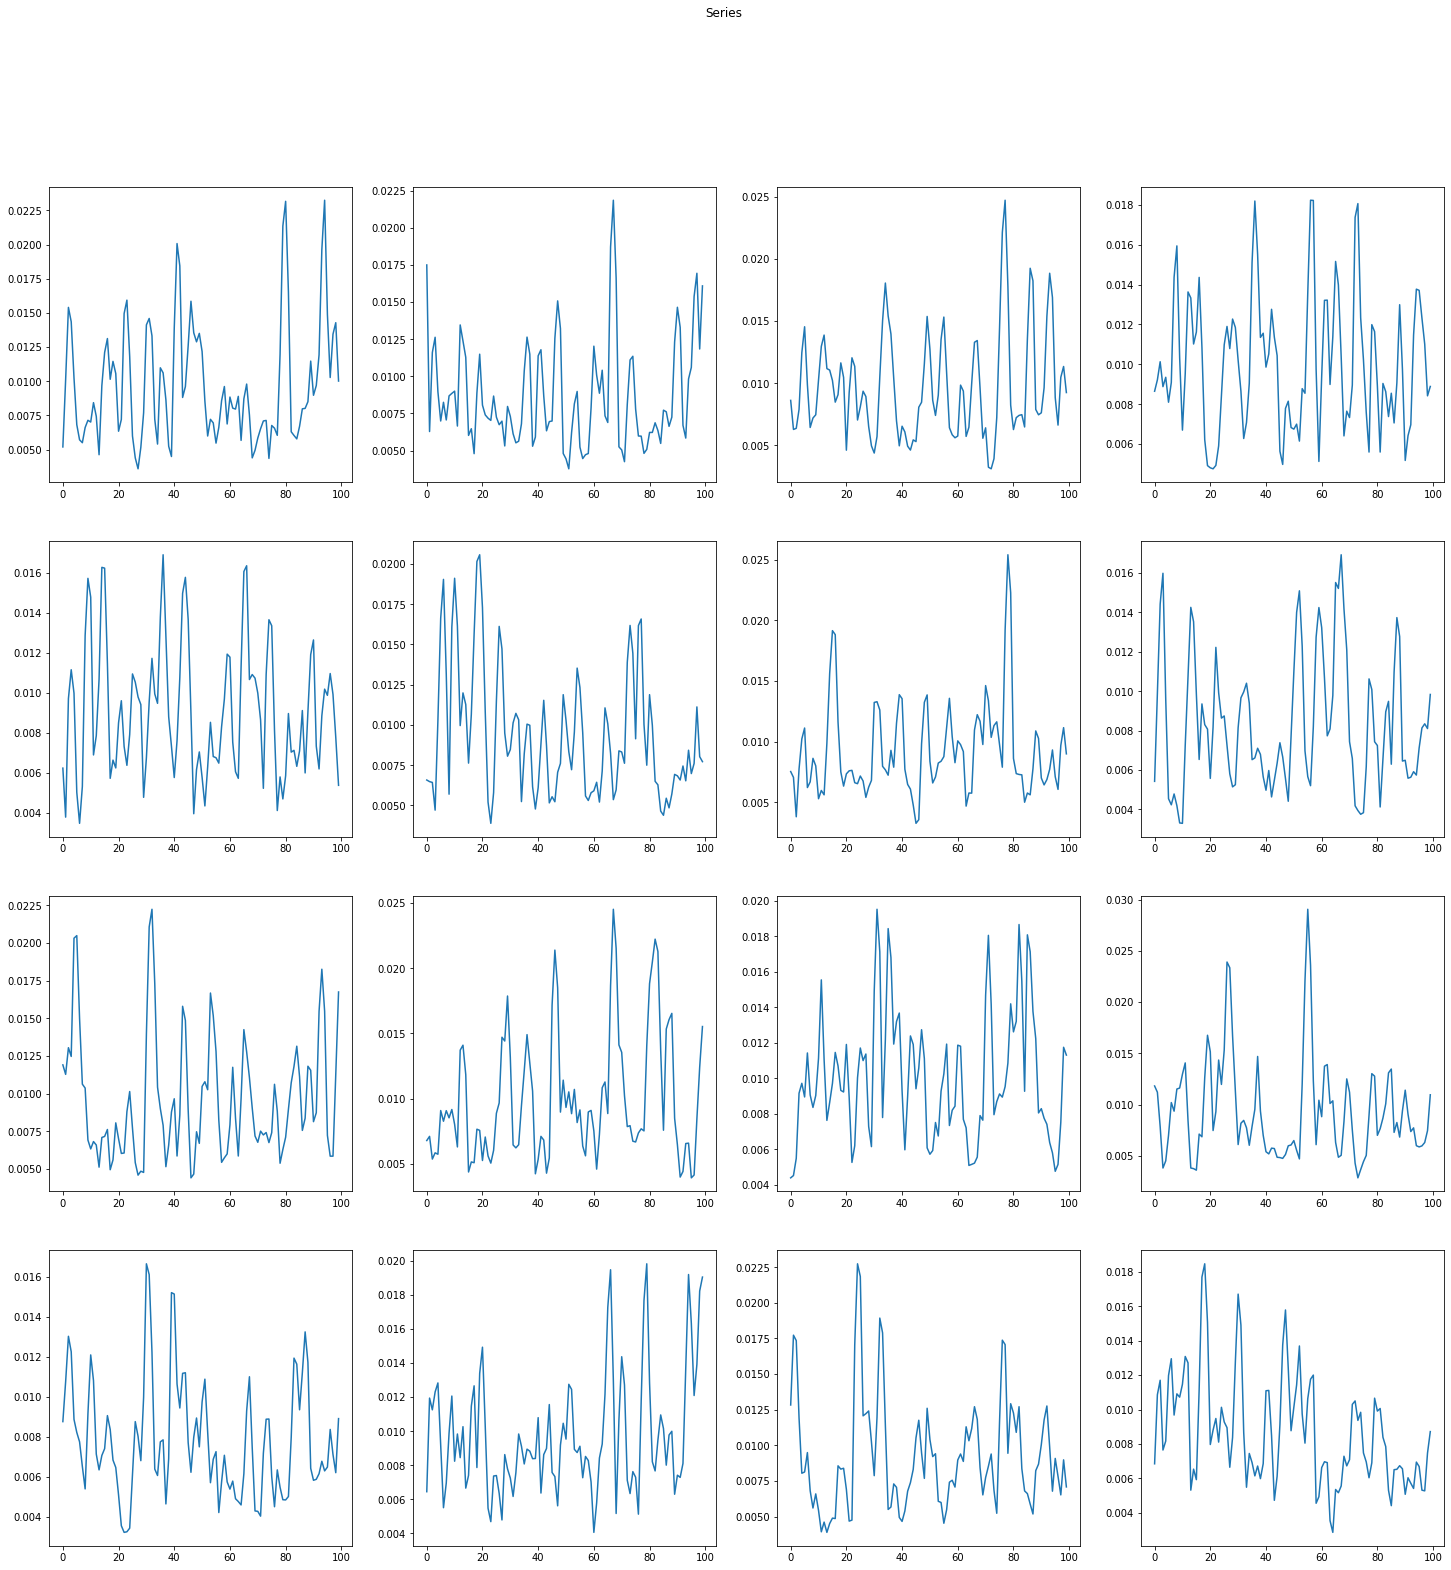

In [8]:
# Before smoothing

fig, axs = plt.subplots(4,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(4):
    for j in range(4):
        if i*4+j+1>len(mySeries_shock): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries_shock[i*4+j])
plt.show()

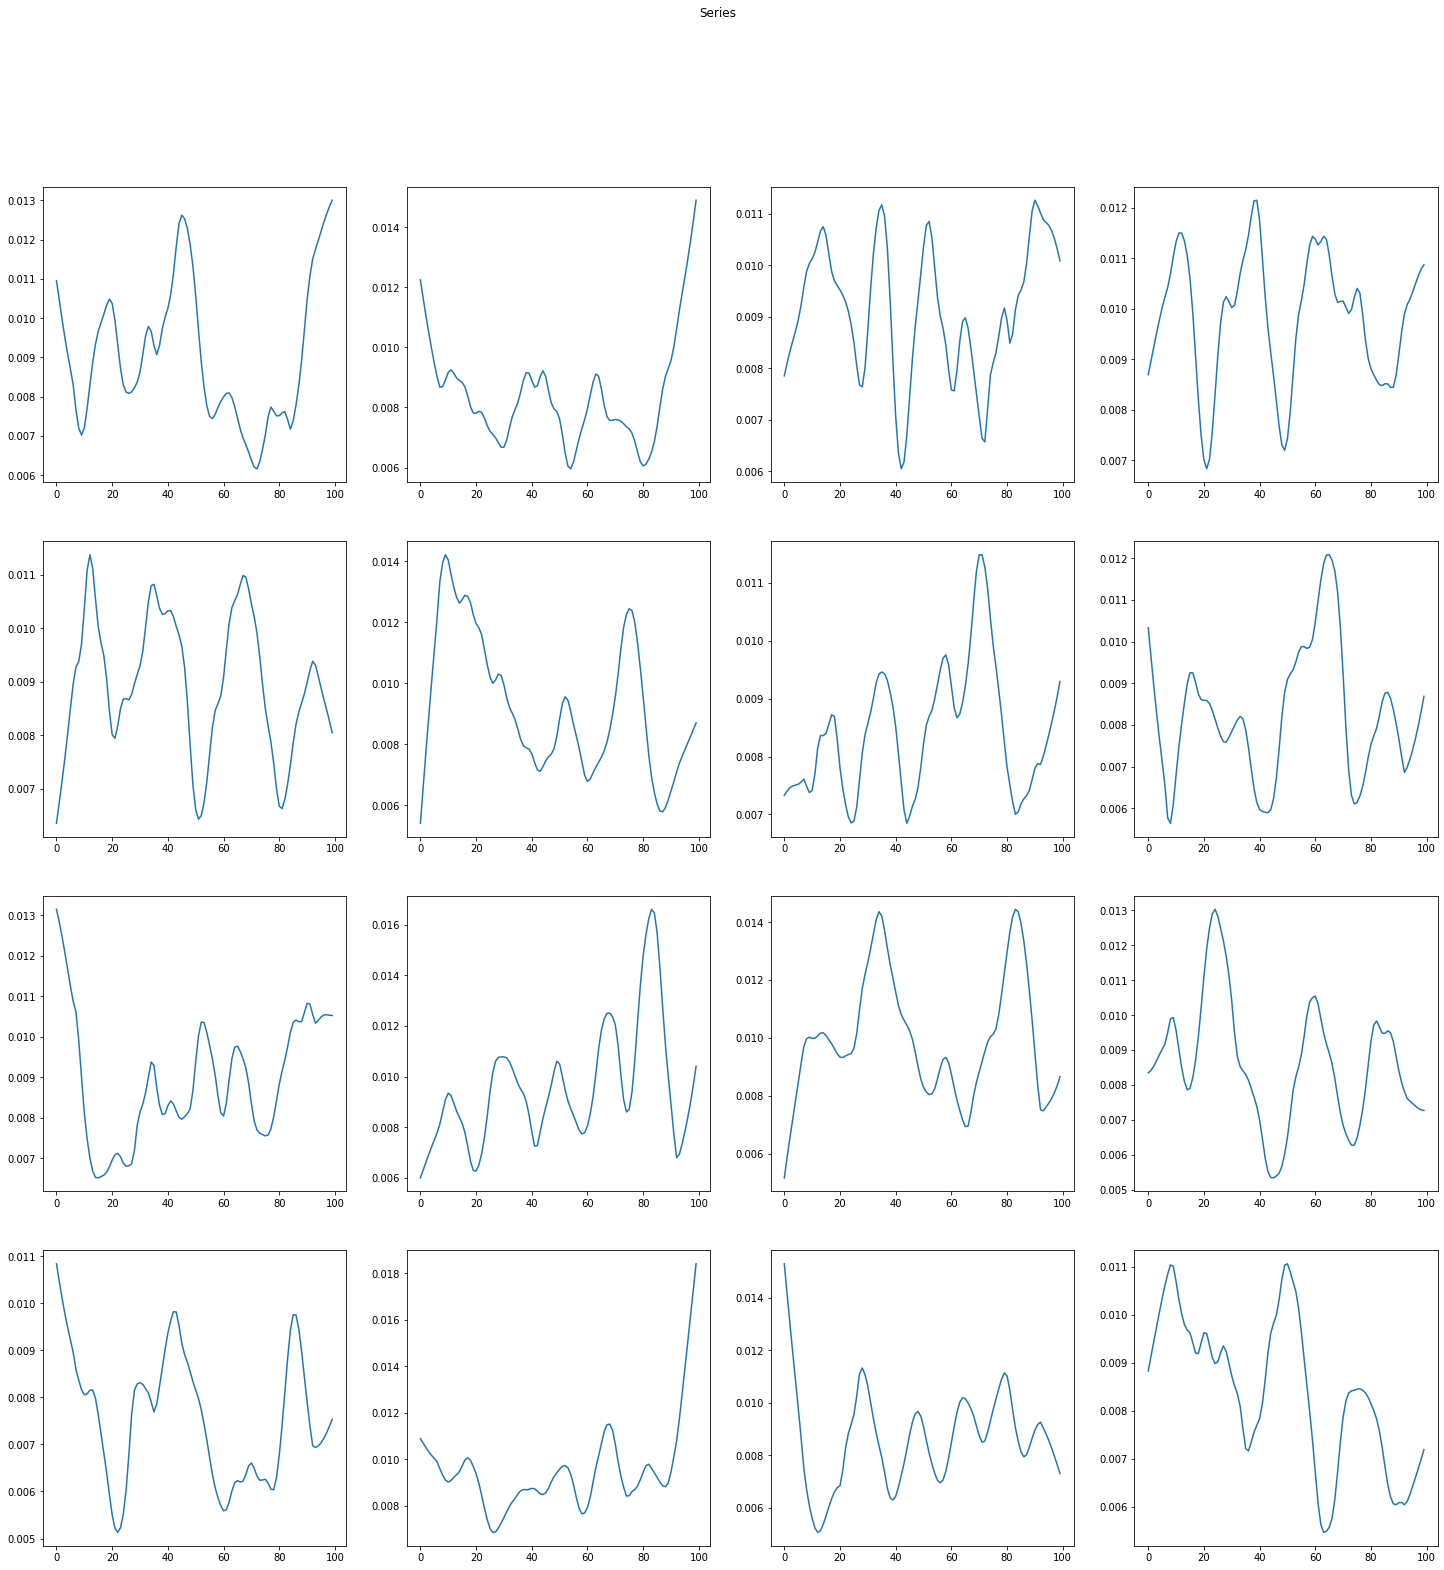

In [9]:
# After smoothing

fig, axs = plt.subplots(4,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(4):
    for j in range(4):
        if i*4+j+1>len(df_loess_shock_15): # pass the others that we can't fill
            continue
        axs[i, j].plot(df_loess_shock_15[i*4+j])
plt.show()

In [10]:
X_shock = TimeSeriesScalerMeanVariance().fit_transform(df_loess_shock_15)
X = StandardScaler().fit_transform(df_loess_shock_15)
X

array([[ 5.45126690e-01,  4.53524599e-01,  3.27016261e-01, ...,
         1.41993131e+00,  1.29259070e+00,  1.17003282e+00],
       [ 9.53412079e-01,  8.76019029e-01,  7.72093472e-01, ...,
         1.78194377e+00,  1.77863630e+00,  1.76457540e+00],
       [-4.33814870e-01, -3.98669551e-01, -3.55420658e-01, ...,
         5.54486971e-01,  3.93855161e-01,  2.53833420e-01],
       ...,
       [ 5.91209852e-02, -4.63340087e-02, -1.79167007e-01, ...,
        -4.18281014e-02, -9.70999817e-02, -1.42740714e-01],
       [-1.52120776e+00, -1.41779146e+00, -1.25942788e+00, ...,
        -2.41790874e-01, -4.36972865e-01, -5.78674492e-01],
       [ 6.64625007e-01,  6.35803926e-01,  5.75086500e-01, ...,
         8.74361048e-02,  4.81966254e-02, -5.74573670e-04]])

In [25]:
cluster_count = math.ceil(math.sqrt(len(X))) 

print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=cluster_count, verbose=True)
y_pred = km.fit_predict(X)

Euclidean k-means
77.967 --> 63.521 --> 61.012 --> 59.712 --> 59.183 --> 58.922 --> 58.778 --> 58.728 --> 58.701 --> 58.693 --> 58.677 --> 58.677 --> 


In [26]:
g = f = math.ceil(math.sqrt(math.sqrt(len(X)))) 
fig, axs = plt.subplots(g, f, figsize=(25,25))
fig.suptitle('Clusters Euclidean k-means')
for yi in range(g):
  for yj in range(f):
    if yi * 5 + yj + 1 > cluster_count:
            continue
    for xx in X[y_pred == yi*5+yj]:
        axs[yi, yj].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi, yj].plot(km.cluster_centers_[yi*5+yj].ravel(), "r-")
    axs[yi, yj].set_title(f"Cluster {yi*5+yj}")
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/ABM/foo0.png') 

Output hidden; open in https://colab.research.google.com to view.

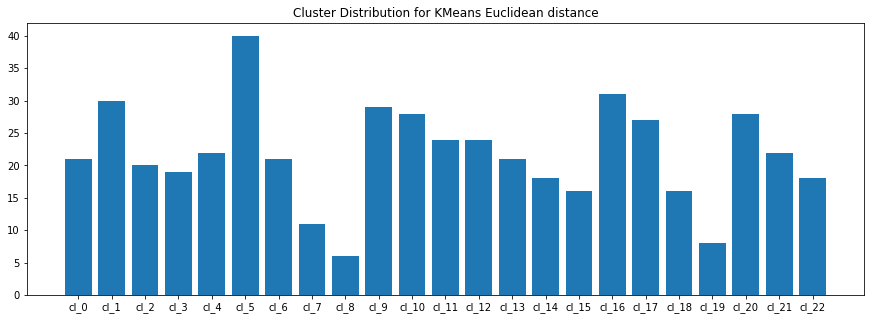

In [27]:
cluster_c = [len(X[y_pred == clust]) for clust in range(cluster_count)]
cluster_n = ["cl_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans Euclidean distance")
plt.bar(cluster_n,cluster_c)
plt.show()

In [30]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=cluster_count,
                          n_init=5,
                          metric="dtw",
                          verbose=True)
y_pred = dba_km.fit_predict(X)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

13.927 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.9s finished


8.719 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    6.2s finished


8.370 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.225 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.6s finished


8.182 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.159 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.150 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.142 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.6s finished


8.128 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


8.118 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.101 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.092 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.085 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


8.077 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


8.073 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.068 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.065 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.065 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

14.010 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    6.2s finished


8.554 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.246 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


8.141 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.083 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.057 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.046 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.042 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.033 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.029 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.029 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

14.256 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.827 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.9s finished


8.427 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.304 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.242 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.9s finished


8.205 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


8.195 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


8.186 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    6.2s finished


8.180 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.6s finished


8.180 --> 
Init 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

13.629 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


8.528 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.6s finished


8.203 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.080 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.021 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


7.966 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


7.938 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


7.906 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.8s finished


7.890 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


7.876 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


7.864 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


7.864 --> 
Init 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

13.977 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.654 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


8.265 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.6s finished


8.163 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


8.097 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.4s finished


8.083 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.7s finished


8.079 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


8.079 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11500 out of 11500 | elapsed:    5.5s finished


In [33]:
g = f = math.ceil(math.sqrt(math.sqrt(len(X)))) 
fig, axs = plt.subplots(g, f, figsize=(25,25))
fig.suptitle('Clusters DTW k-means')
for yi in range(g):
  for yj in range(f):
    if yi * 5 + yj + 1 > cluster_count:
            continue
    for xx in X[y_pred == yi*5+yj]:
        axs[yi, yj].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi, yj].plot(dba_km.cluster_centers_[yi*5+yj].ravel(), "r-")
    axs[yi, yj].set_title(f"Cluster {yi*5+yj}")
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/ABM/foo1.png') 

Output hidden; open in https://colab.research.google.com to view.

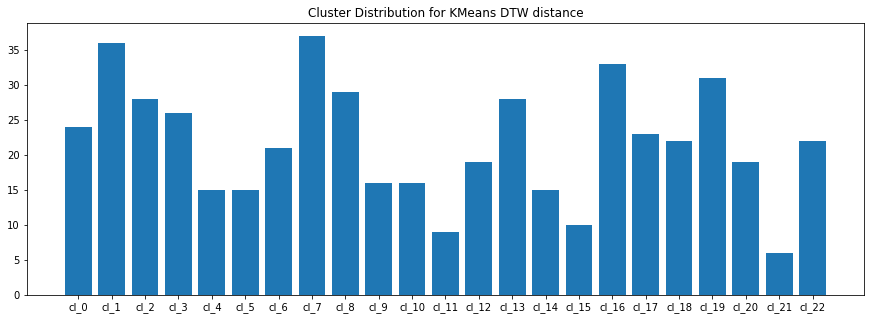

In [34]:
cluster_c = [len(X[y_pred == clust]) for clust in range(cluster_count)]
cluster_n = ["cl_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans DTW distance")
plt.bar(cluster_n,cluster_c)
plt.show()

In [37]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_count,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True)
y_pred = sdtw_km.fit_predict(X)

Soft-DTW k-means
236.143 --> 83.314 --> 76.956 --> 75.239 --> 74.957 --> 74.662 --> 74.589 --> 74.525 --> 74.511 --> 74.423 --> 74.394 --> 74.397 --> 74.387 --> 74.378 --> 74.362 --> 74.362 --> 74.359 --> 74.355 --> 74.348 --> 74.306 --> 74.295 --> 74.295 --> 74.285 --> 74.285 --> 74.282 --> 74.270 --> 74.266 --> 74.266 --> 74.261 --> 74.261 --> 74.256 --> 74.255 --> 74.253 --> 74.251 --> 74.195 --> 74.158 --> 74.156 --> 74.141 --> 74.143 --> 74.136 --> 74.130 --> 74.130 --> 74.130 --> 74.127 --> 74.126 --> 74.127 --> 74.121 --> 74.123 --> 74.121 --> 74.122 --> 


In [39]:
g = f = math.ceil(math.sqrt(math.sqrt(len(X)))) 
fig, axs = plt.subplots(g, f, figsize=(25,25))
fig.suptitle('Clusters Soft-DTW k-means')
for yi in range(g):
  for yj in range(f):
    if yi * 5 + yj + 1 > cluster_count: # pass the others that we can't fill
            continue
    for xx in X[y_pred == yi*5+yj]:
        axs[yi, yj].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi, yj].plot(sdtw_km.cluster_centers_[yi*5+yj].ravel(), "r-")
    axs[yi, yj].set_title(f"Cluster {yi*5+yj}")
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/ABM/foo2.png')             

Output hidden; open in https://colab.research.google.com to view.

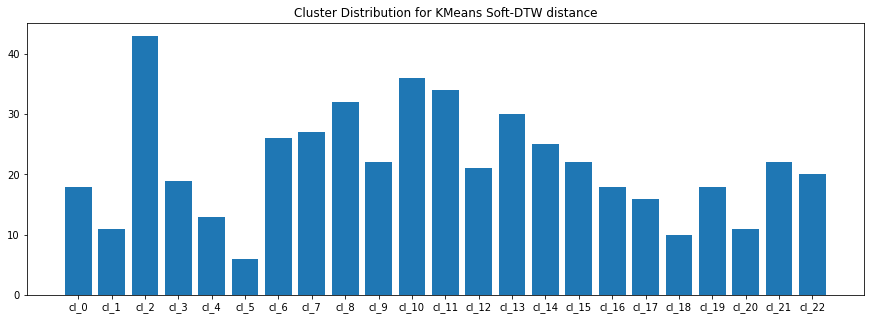

In [41]:
cluster_c = [len(X[y_pred == clust]) for clust in range(cluster_count)]
cluster_n = ["cl_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans Soft-DTW distance")
plt.bar(cluster_n,cluster_c)
plt.show()

MonoSOM clustering

In [103]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(X))))

som = MiniSom(som_x, som_y, np.shape(X)[1], sigma=0.5, learning_rate = 0.1)

som.random_weights_init(X)
som.train(X, 500000)

In [104]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")
    plt.show()

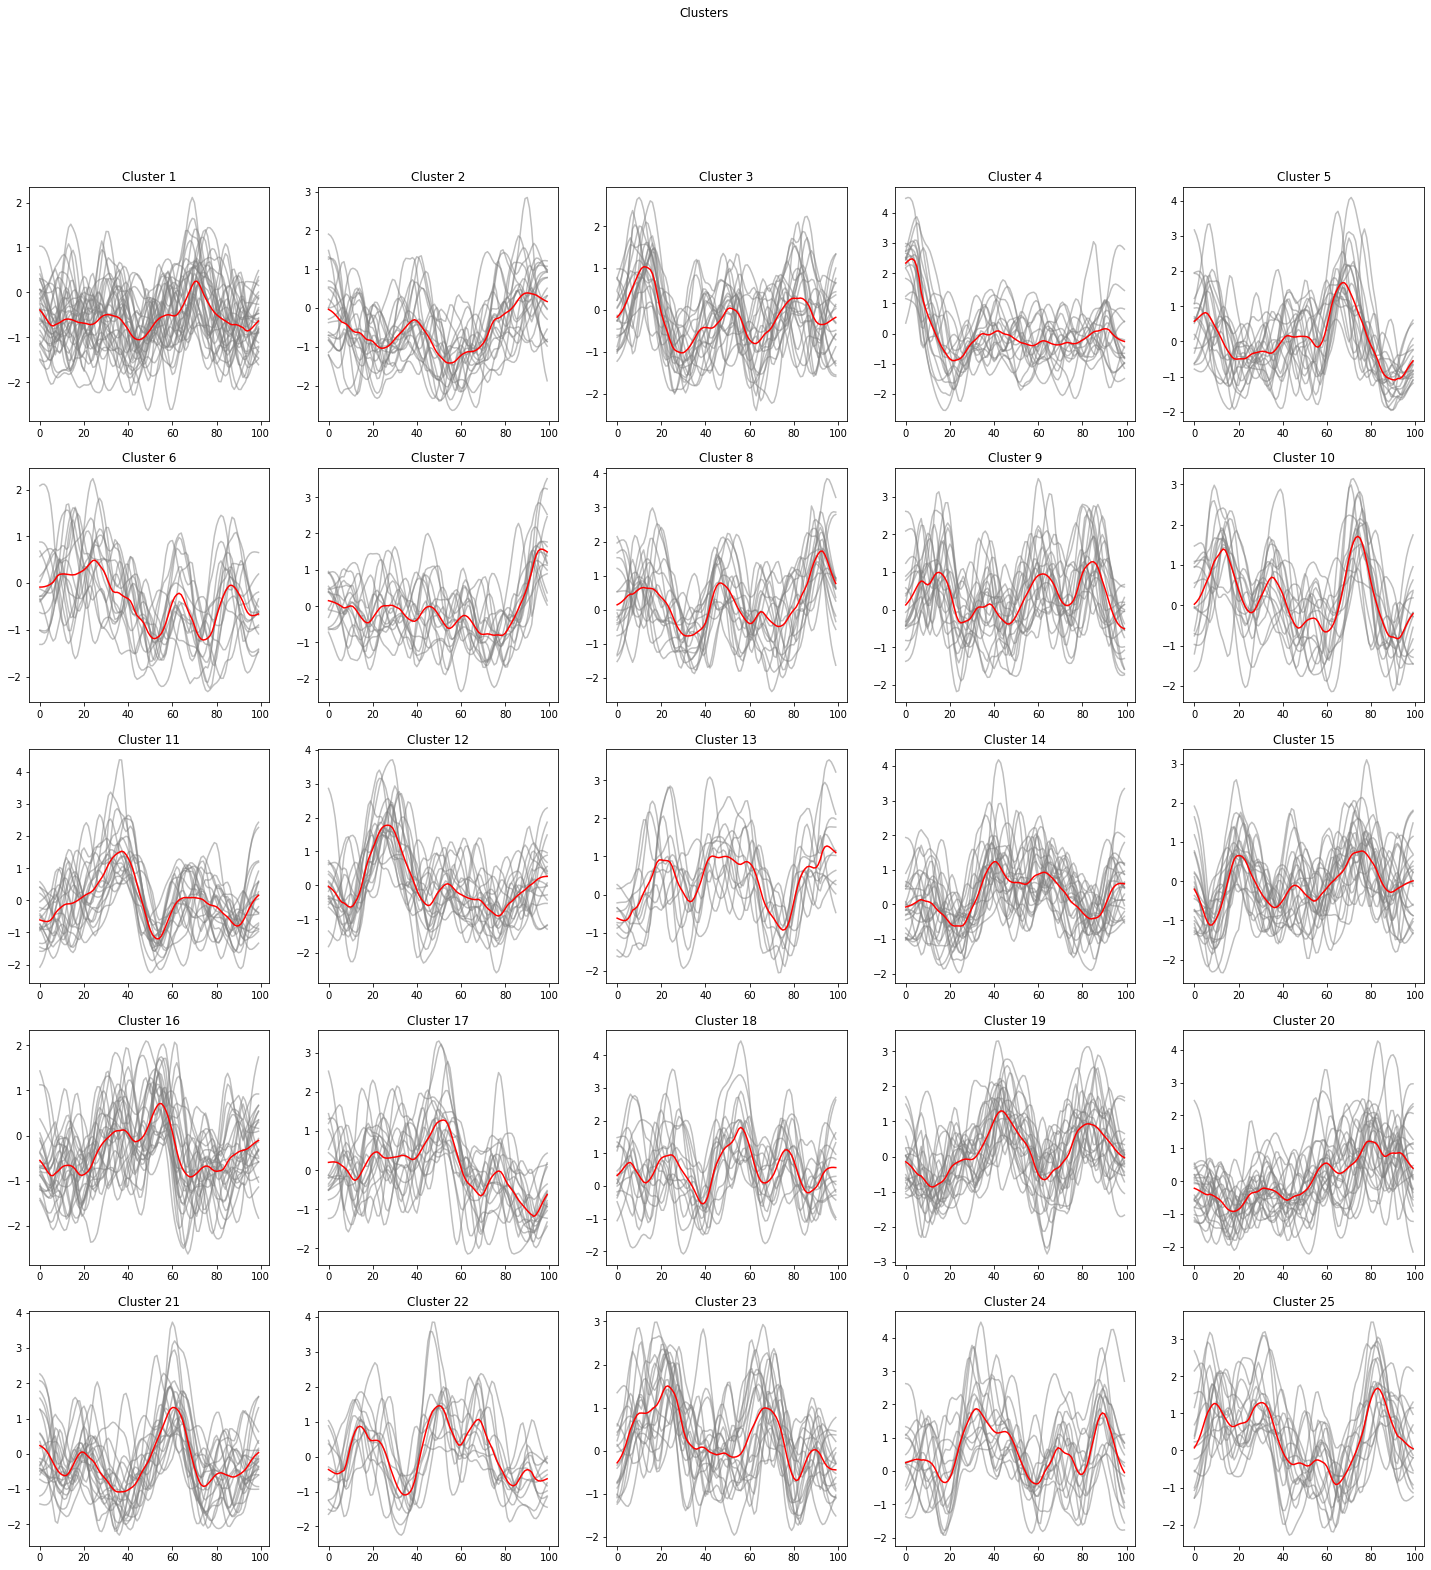

In [105]:
win_map = som.win_map(X)
# Returns the mapping of the winner nodes and inputs
plot_som_series_averaged_center(som_x, som_y, win_map)

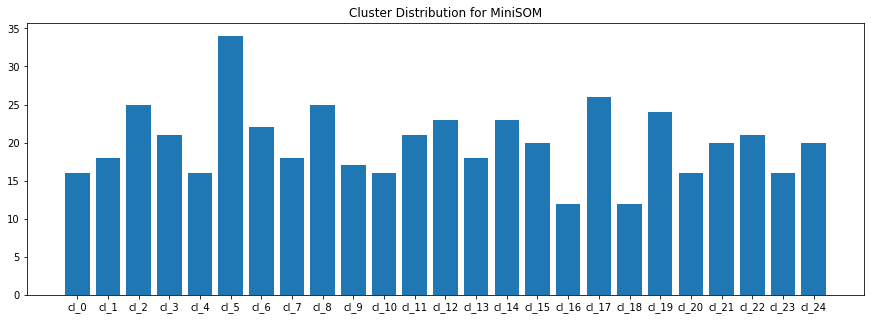

In [112]:
cluster_c = [len(win_map[clust]) for clust in win_map.keys()]
cluster_n = ["cl_"+str(i) for i in range(len(win_map.keys()))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for MiniSOM")
plt.bar(cluster_n,cluster_c)
plt.show()

Clustering using PCA method

In [95]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(X)

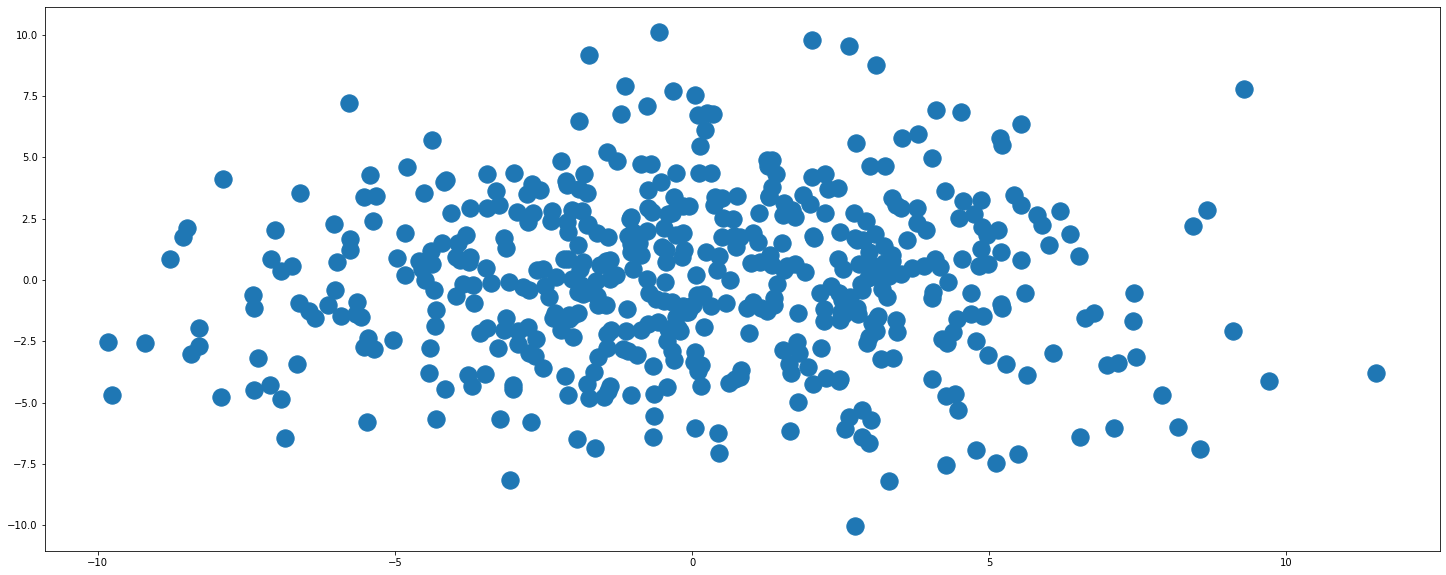

In [43]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [44]:
print(mySeries_transformed[0:5])

[[ 0.14195147 -4.32274728]
 [-5.02966366 -2.44460043]
 [ 0.04189993 -2.95325051]
 [ 3.61565695  1.62615864]
 [-0.1646982   0.9541403 ]]


PCA + K-means

In [45]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=50000)

labels = kmeans.fit_predict(mySeries_transformed)

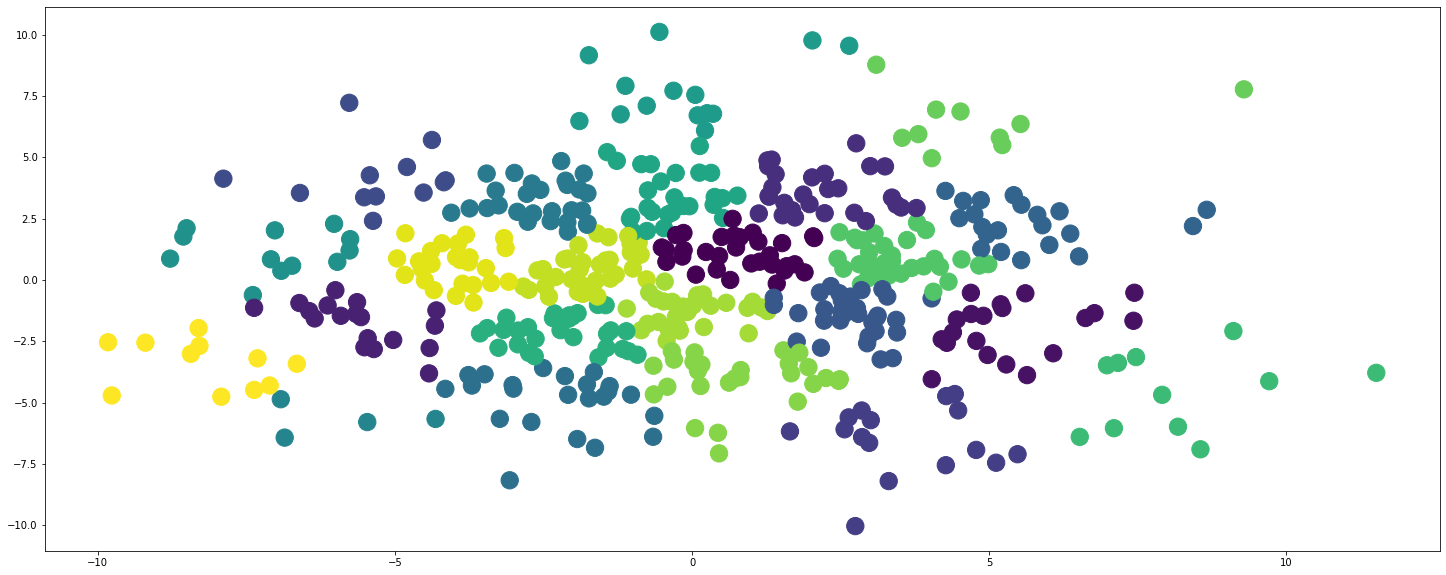

In [46]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

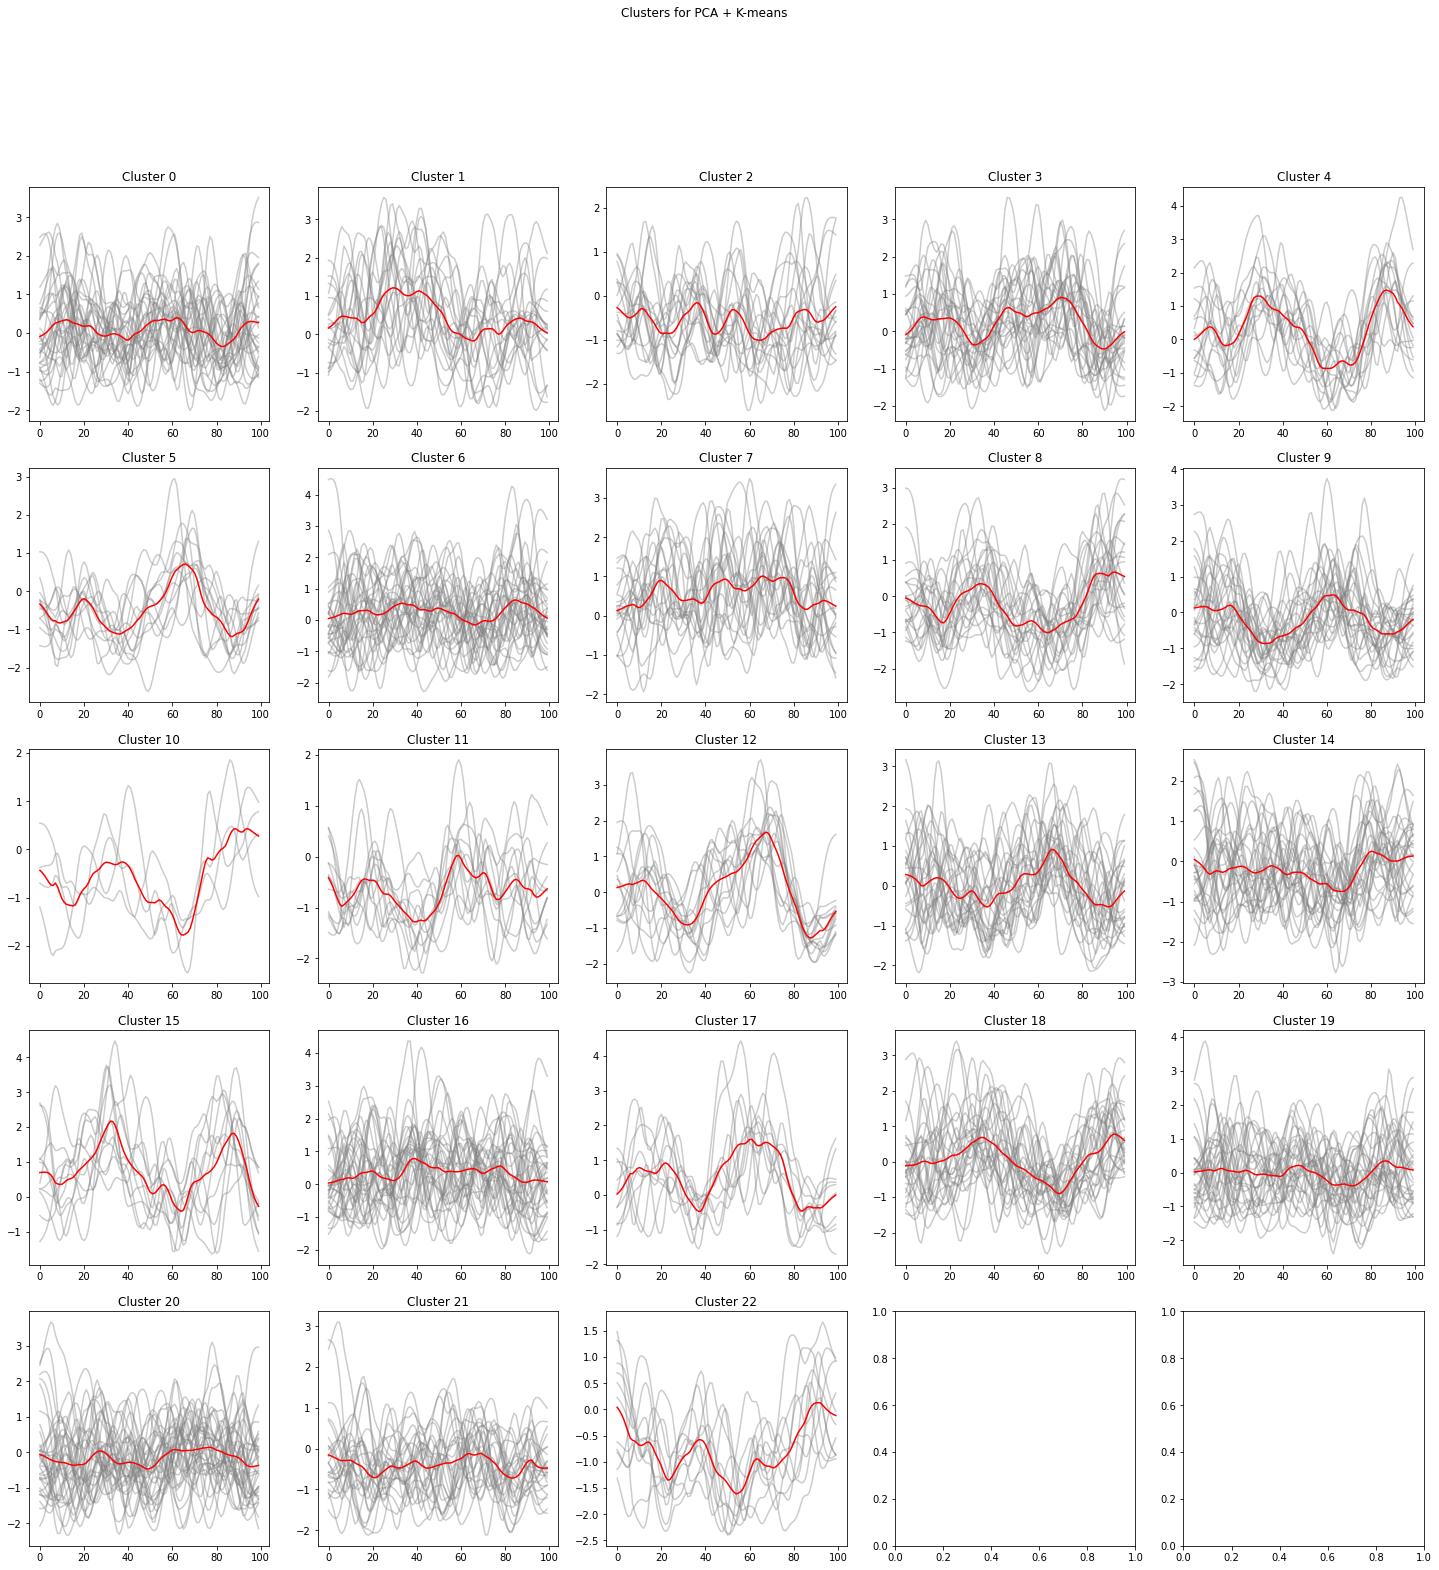

In [49]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters for PCA + K-means')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(X[i],c="gray",alpha=0.4)
                cluster.append(X[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

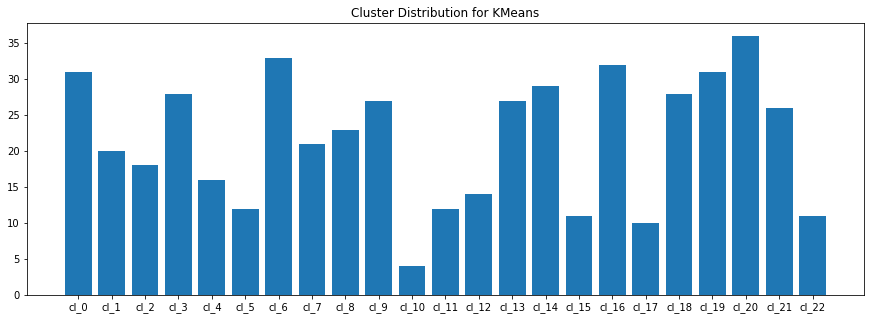

In [50]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cl_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
PCA + DBSCAN

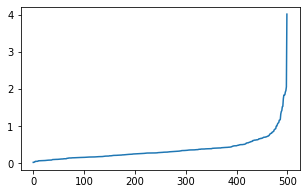

In [51]:
# Find eps for DBSCAN

neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(mySeries_transformed) # fitting the data to the object
distances, indices=nbrs.kneighbors(mySeries_transformed) 
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show()

In [96]:
db = DBSCAN(eps=1.1, min_samples=3, n_jobs=-1).fit(mySeries_transformed)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

y_pred = db.fit_predict(mySeries_transformed)

Estimated number of clusters: 9
Estimated number of noise points: 18


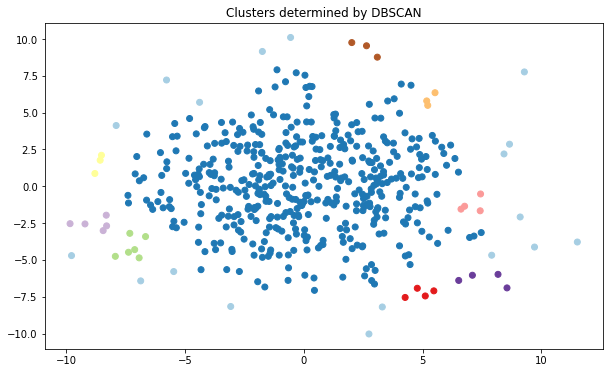

In [97]:
plt.figure(figsize=(10,6))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=y_pred, cmap='Paired')
plt.title("Clusters determined by DBSCAN")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [99]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  5,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  4, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

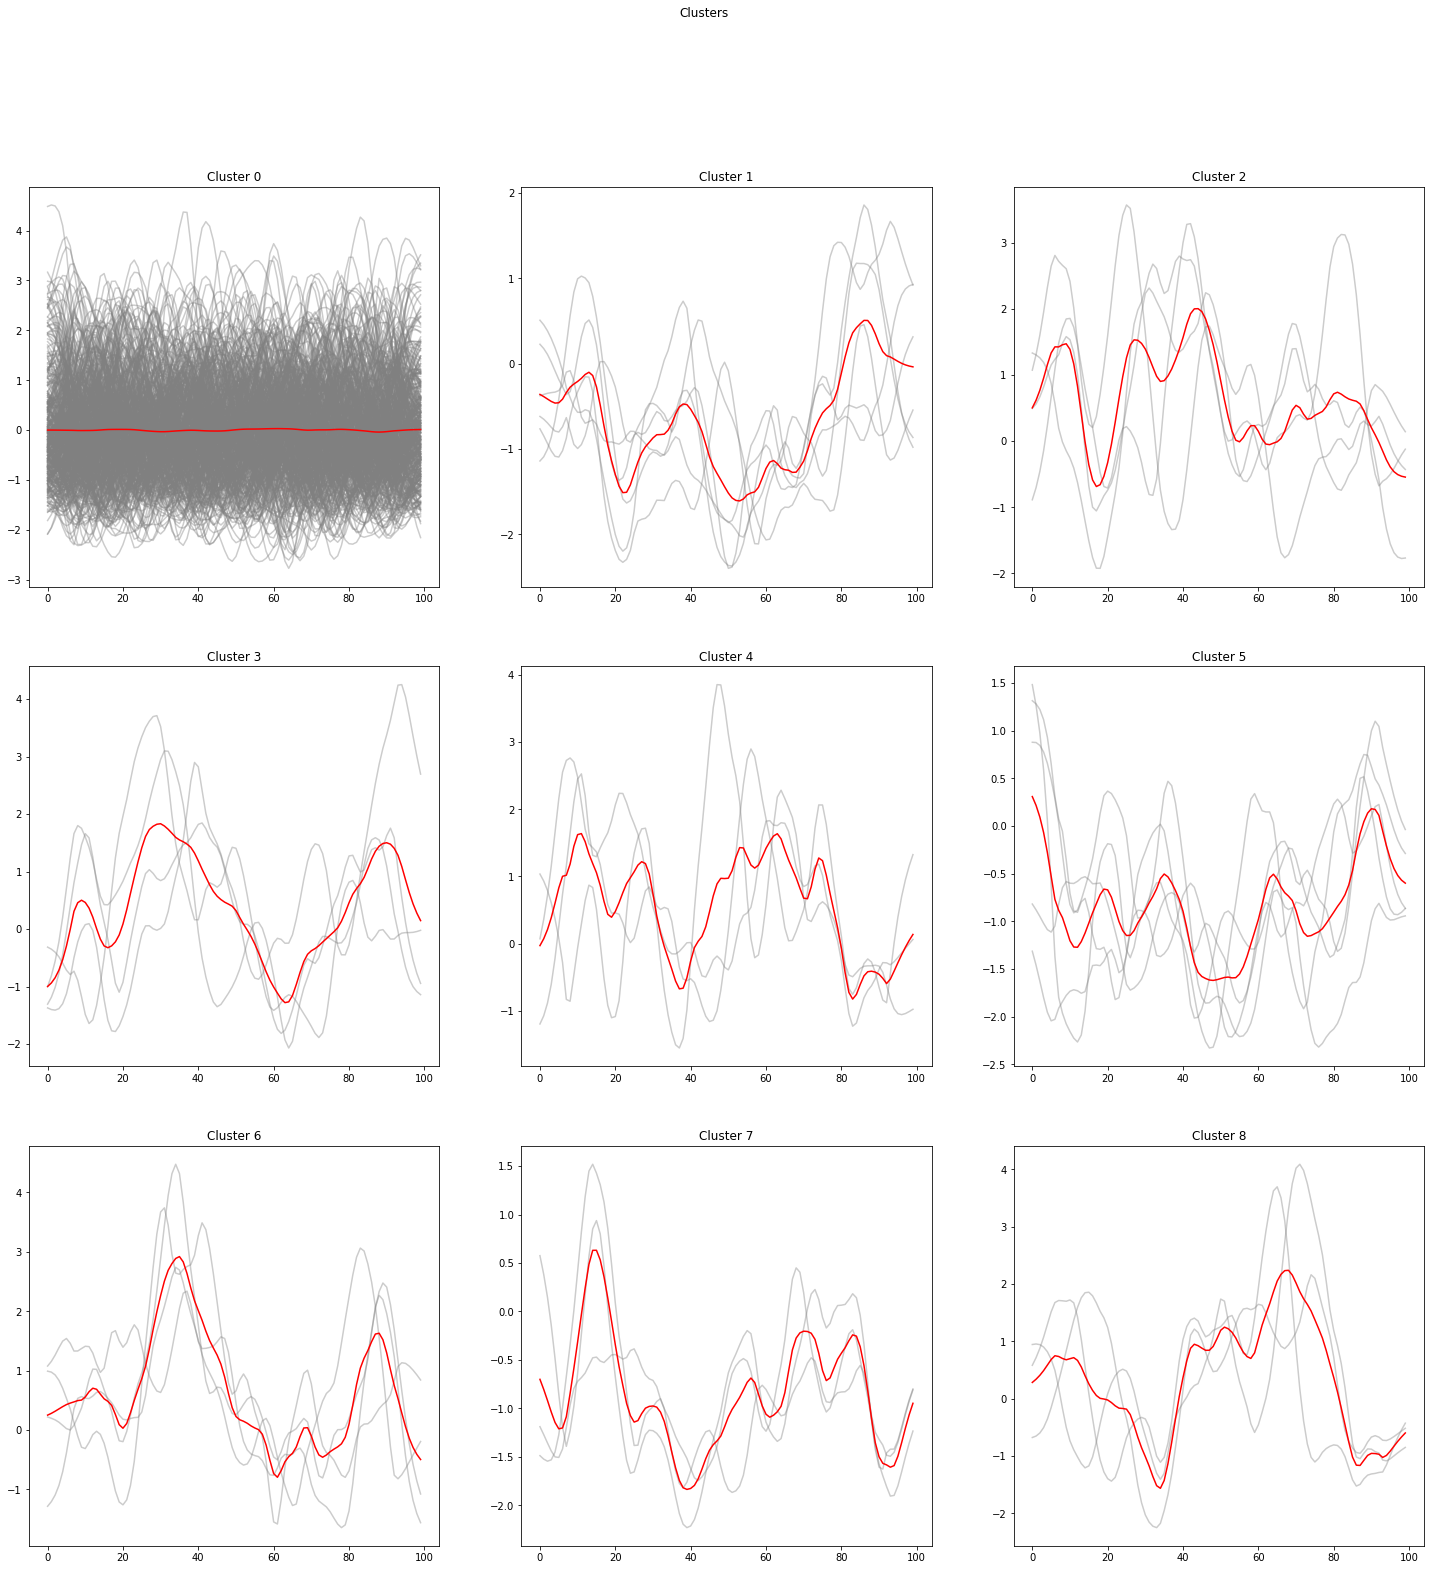

In [100]:
plot_count = math.ceil(math.sqrt(n_clusters_))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
  if label != -1:
    cluster = []
    for i in range(len(labels)):
      if(labels[i]==label):
        axs[row_i, column_j].plot(X[i],c="gray",alpha=0.4)
        cluster.append(X[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

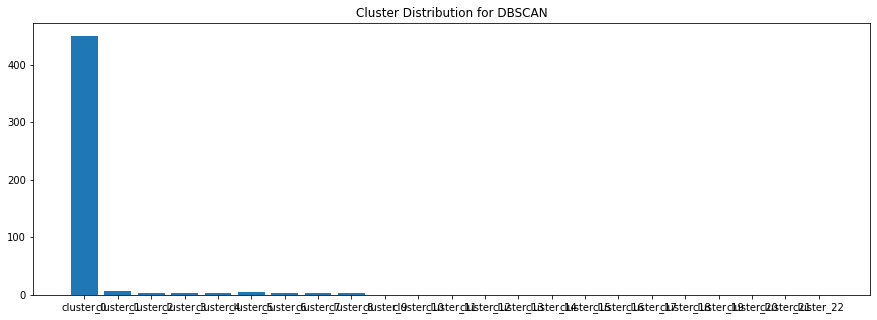

In [101]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [130]:
# Identify Noise
n_noise = list(labels).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Estimated no. of noise points: 34
